In [1]:
!mkdir data

In [2]:

!pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


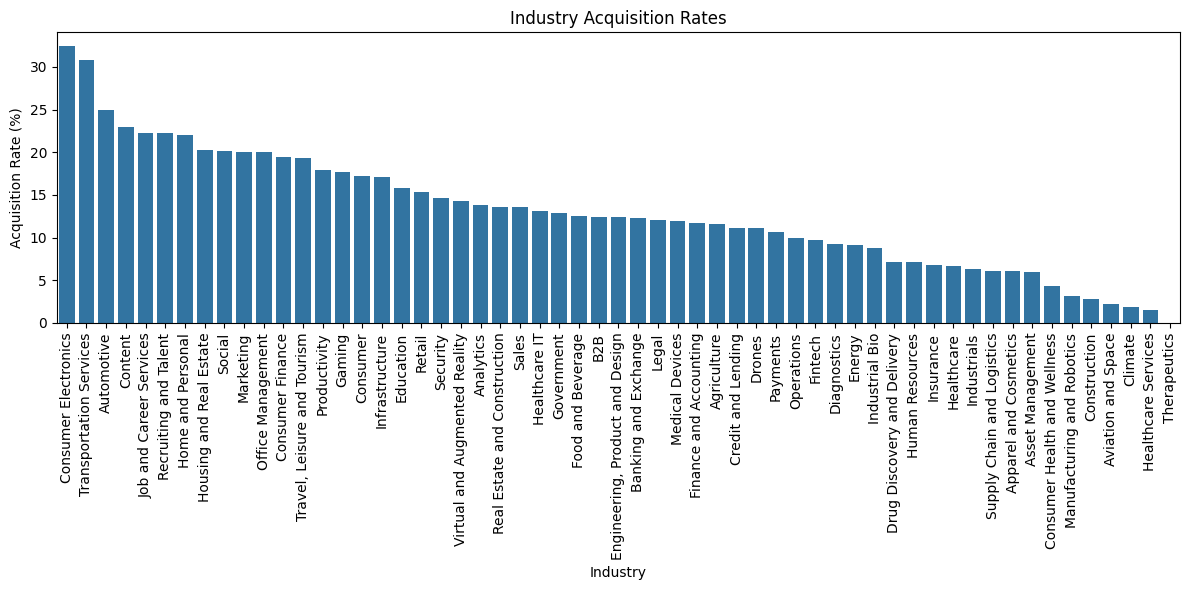

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
companies = pd.read_csv('./data/companies.csv')
industries = pd.read_csv('./data/industries.csv')

merged_data = pd.merge(companies, industries, left_on='id', right_on='id', how='left')

# Count companies by industry
industry_counts = merged_data['industry'].value_counts()

# Filter for 'acquired' companies
acquired_companies = merged_data[merged_data['status'] == 'Acquired']

# Count acquired companies by industry
acquired_counts = acquired_companies['industry'].value_counts()

# Prepare data for visualization
industry_trends = pd.DataFrame({
    'Total Companies': industry_counts,
    'Acquired Companies': acquired_counts
}).fillna(0)

# Calculate acquisition rates
industry_trends['Acquisition Rate'] = (industry_trends['Acquired Companies'] / industry_trends['Total Companies']) * 100

# Sort by acquisition rate for visualization
industry_trends_sorted = industry_trends.sort_values('Acquisition Rate', ascending=False)

# Visualize Industry Trends
plt.figure(figsize=(12, 6))
sns.barplot(x=industry_trends_sorted.index, y='Acquisition Rate', data=industry_trends_sorted)
plt.title('Industry Acquisition Rates')
plt.xlabel('Industry')
plt.ylabel('Acquisition Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

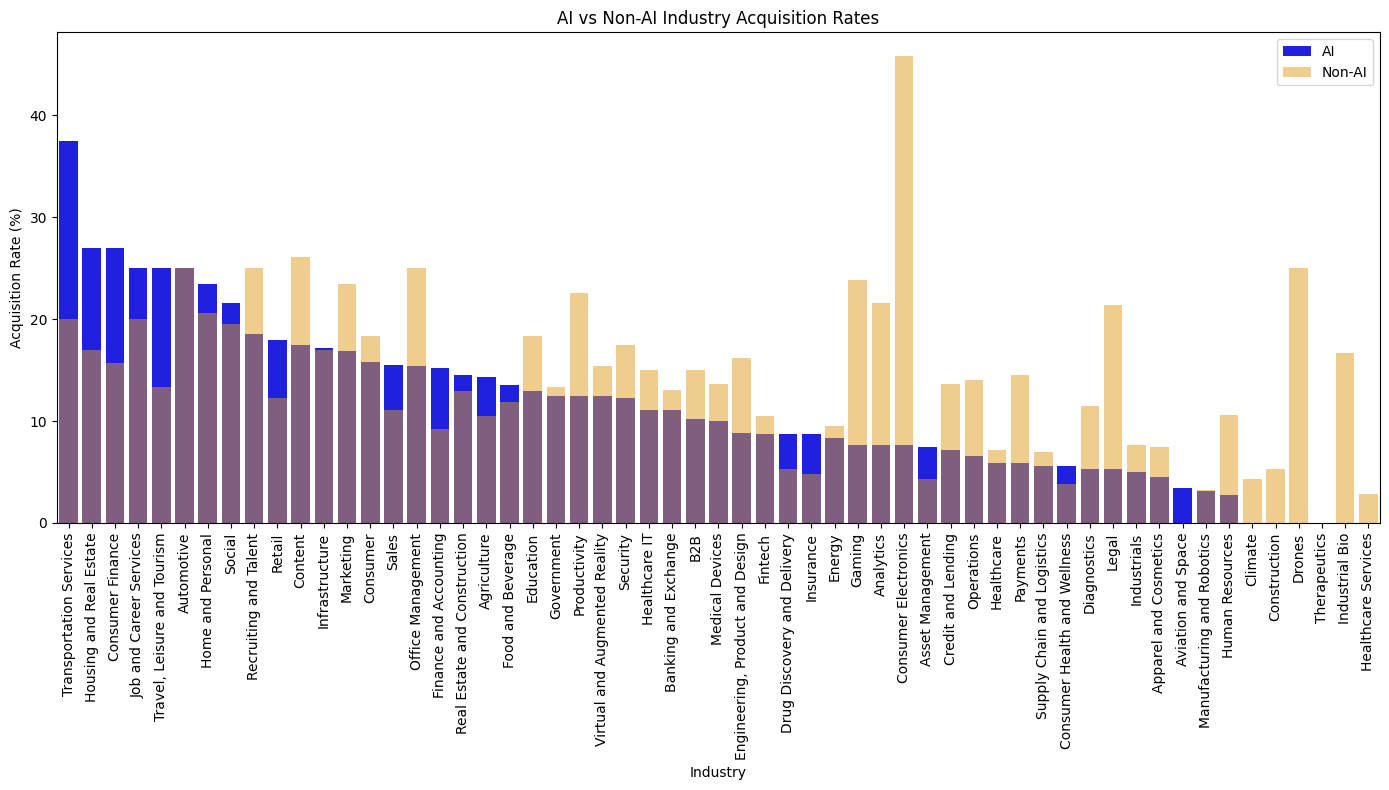

<Figure size 1400x800 with 0 Axes>

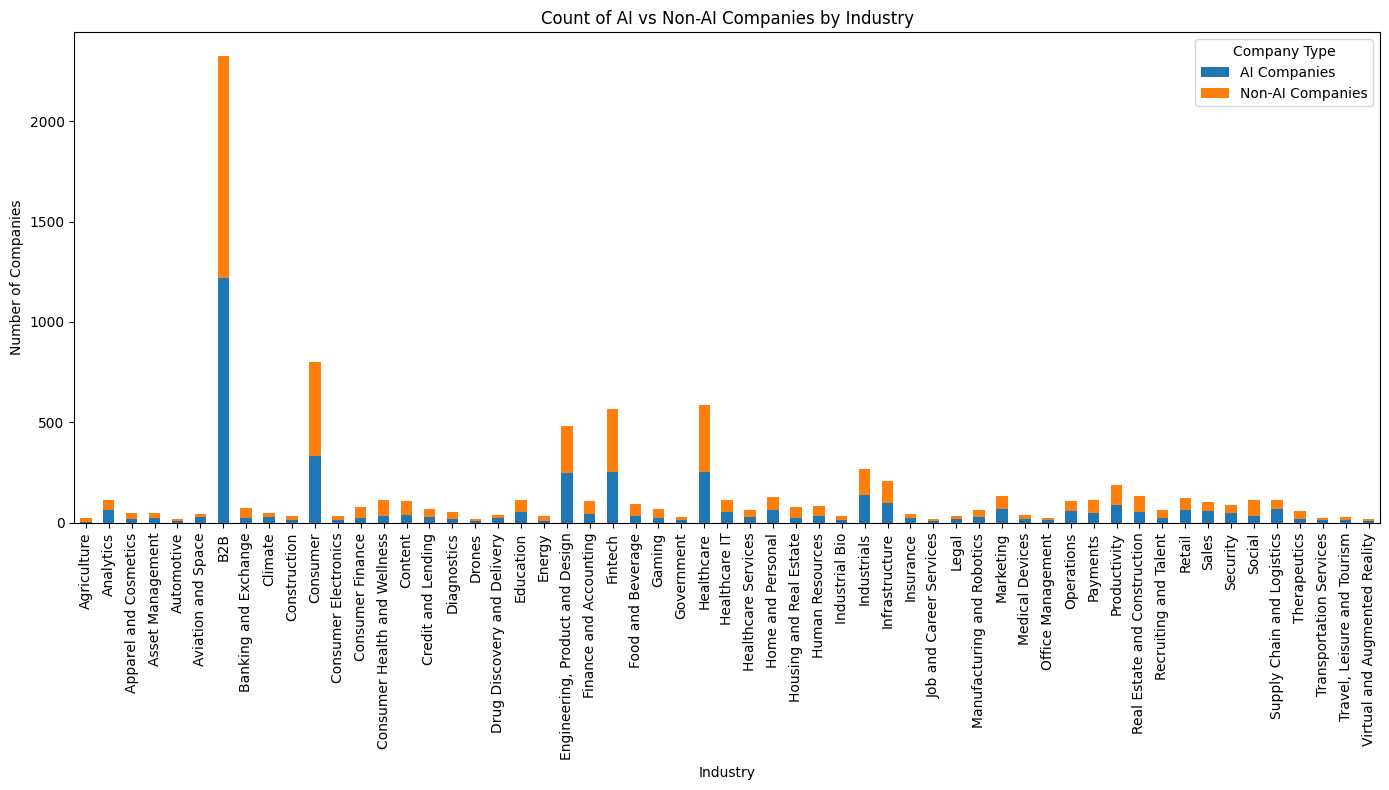

In [9]:
merged_data['is_AI'] = merged_data['longDescription'].str.contains('AI', case=False, na=False)

# Count companies by industry and whether they are AI companies
industry_ai_counts = merged_data.groupby(['industry', 'is_AI']).size().unstack().fillna(0)
industry_ai_counts.columns = ['Non-AI Companies', 'AI Companies']

# Filter for 'acquired' companies
acquired_companies = merged_data[merged_data['status'] == 'Acquired']
acquired_ai_counts = acquired_companies.groupby(['industry', 'is_AI']).size().unstack().fillna(0)
acquired_ai_counts.columns = ['Non-AI Acquired', 'AI Acquired']

# Prepare data for visualization
industry_trends = industry_ai_counts.join(acquired_ai_counts, how='outer').fillna(0)

# Calculate acquisition rates for AI and Non-AI companies
industry_trends['AI Acquisition Rate'] = (industry_trends['AI Acquired'] / industry_trends['AI Companies']) * 100
industry_trends['Non-AI Acquisition Rate'] = (industry_trends['Non-AI Acquired'] / industry_trends['Non-AI Companies']) * 100

# Sort by AI acquisition rate for visualization
industry_trends_sorted = industry_trends.sort_values('AI Acquisition Rate', ascending=False)

# Visualize Industry Trends for AI vs Non-AI
plt.figure(figsize=(14, 8))

# Plotting AI and Non-AI acquisition rates
sns.barplot(x=industry_trends_sorted.index, y='AI Acquisition Rate', data=industry_trends_sorted, color='blue', label='AI')
sns.barplot(x=industry_trends_sorted.index, y='Non-AI Acquisition Rate', data=industry_trends_sorted, color='orange', alpha=0.5, label='Non-AI')

plt.title('AI vs Non-AI Industry Acquisition Rates')
plt.xlabel('Industry')
plt.ylabel('Acquisition Rate (%)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Additional bar plot for count of AI vs Non-AI companies by industry
plt.figure(figsize=(14, 8))
industry_trends[['AI Companies', 'Non-AI Companies']].plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Count of AI vs Non-AI Companies by Industry')
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.xticks(rotation=90)
plt.legend(title='Company Type')
plt.tight_layout()
plt.show()

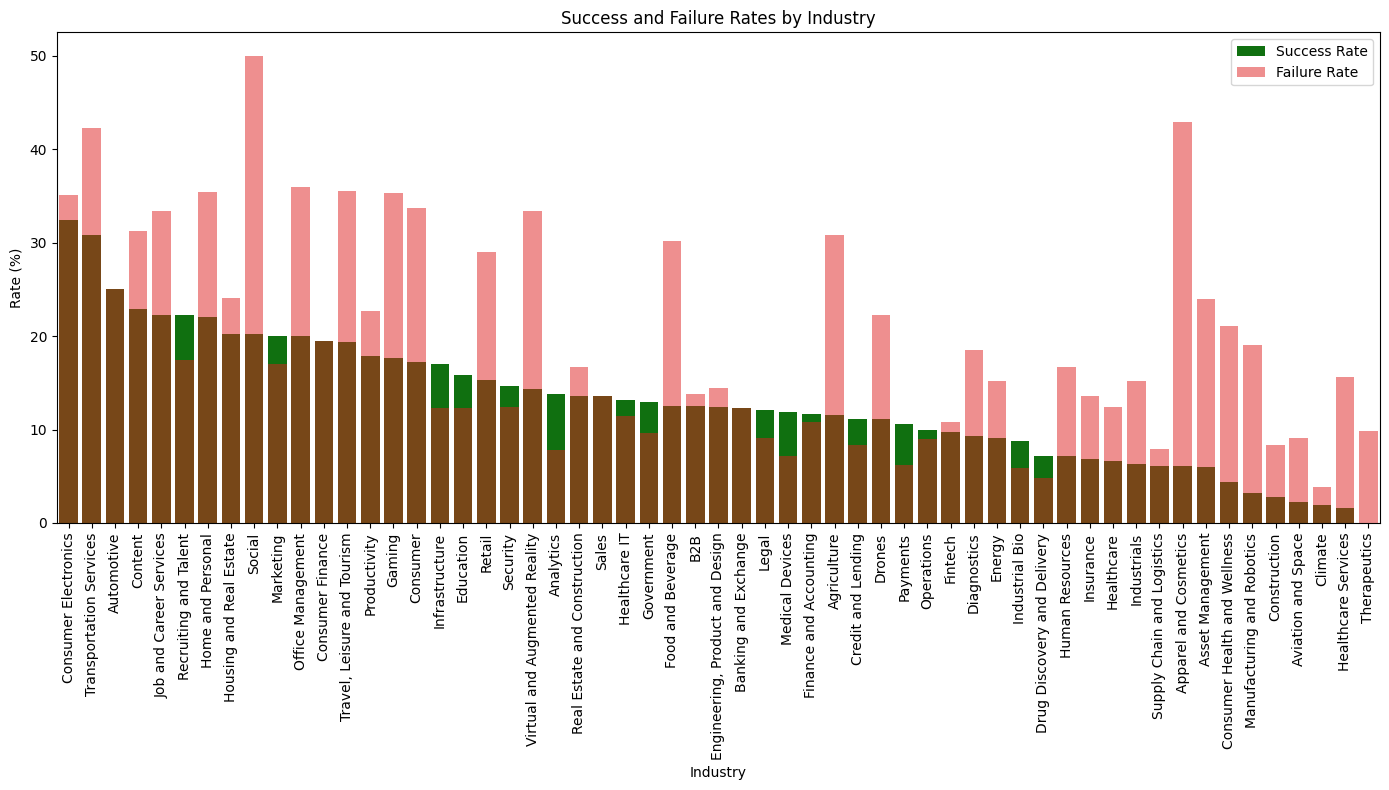

<Figure size 1400x800 with 0 Axes>

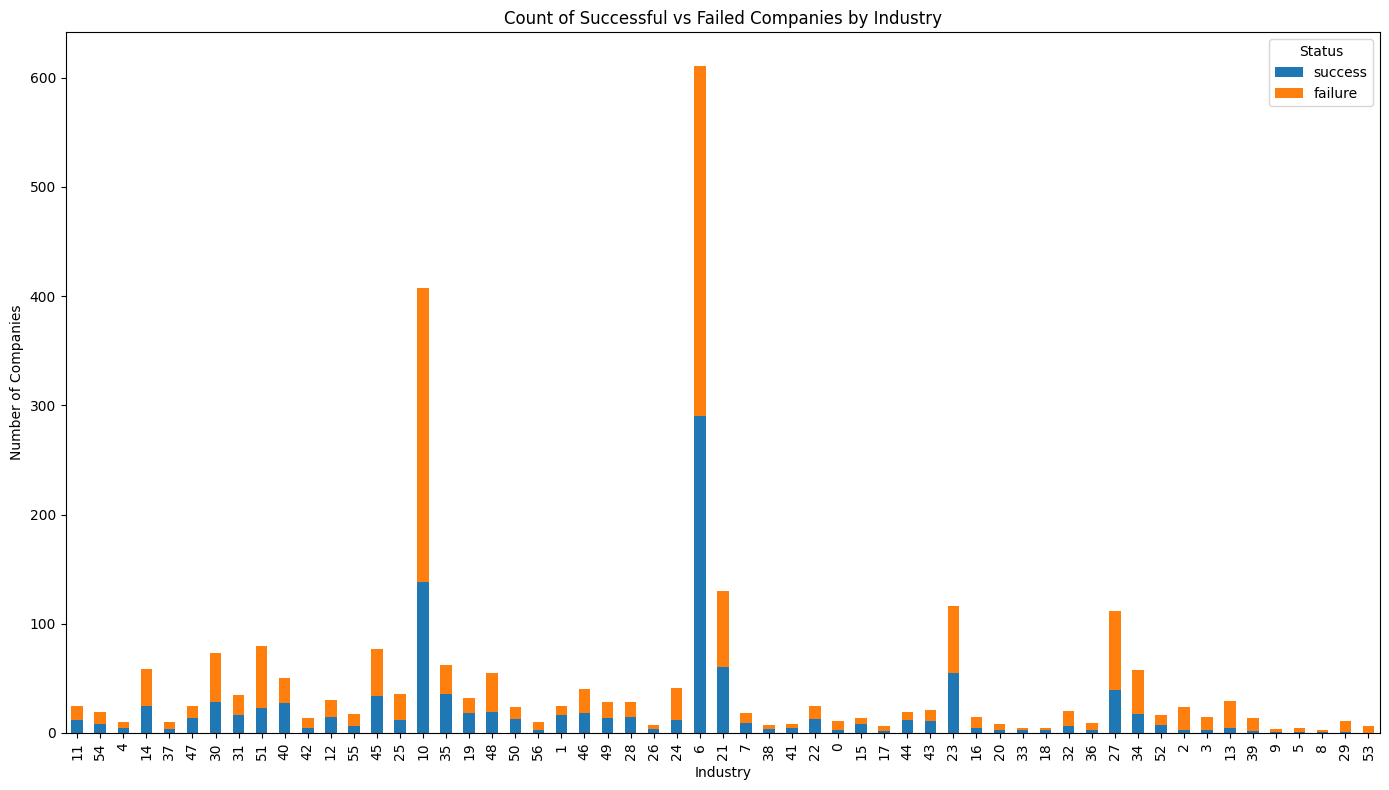

In [11]:
merged_data['success'] = merged_data['status'].apply(lambda x: 1 if x in ['Acquired', 'operating'] else 0)
merged_data['failure'] = merged_data['status'].apply(lambda x: 1 if x in ['Inactive', 'failed'] else 0)

# Group by industry to get counts of successful and failed companies
industry_performance = merged_data.groupby('industry').agg({
    'success': 'sum',
    'failure': 'sum',
    'id': 'count'  # Total companies in the industry
}).reset_index()

industry_performance.rename(columns={'id': 'total_companies'}, inplace=True)

# Calculate success and failure rates
industry_performance['success_rate'] = (industry_performance['success'] / industry_performance['total_companies']) * 100
industry_performance['failure_rate'] = (industry_performance['failure'] / industry_performance['total_companies']) * 100

# Sort industries by success rate for visualization
industry_performance_sorted = industry_performance.sort_values('success_rate', ascending=False)

# Visualize Best (highest success rate) and Worst (highest failure rate) Companies by Industry
plt.figure(figsize=(14, 8))

# Plot success rate
sns.barplot(x='industry', y='success_rate', data=industry_performance_sorted, color='green', label='Success Rate')
plt.title('Success and Failure Rates by Industry')
plt.xlabel('Industry')
plt.ylabel('Rate (%)')
plt.xticks(rotation=90)

# Add failure rate on the same plot for comparison
sns.barplot(x='industry', y='failure_rate', data=industry_performance_sorted, color='red', alpha=0.5, label='Failure Rate')

plt.legend()
plt.tight_layout()
plt.show()

# Additional visualization for raw counts
plt.figure(figsize=(14, 8))
industry_performance_sorted[['success', 'failure']].plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Count of Successful vs Failed Companies by Industry')
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.xticks(rotation=90)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

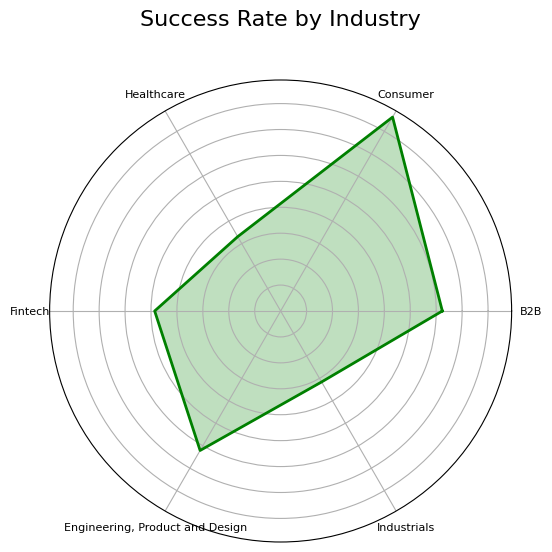

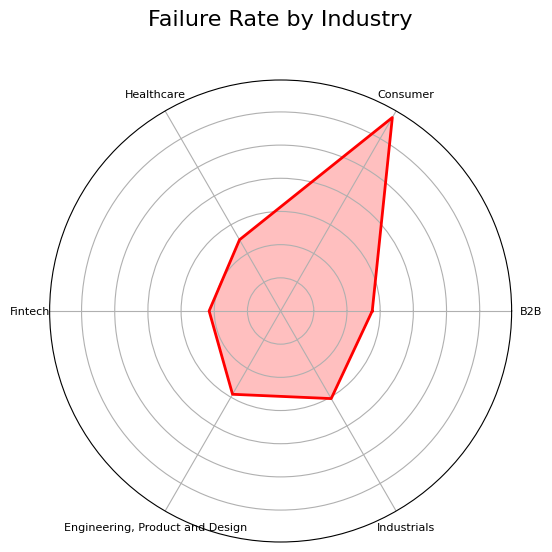

In [12]:

# Group by industry to get counts of successful and failed companies
industry_performance = merged_data.groupby('industry').agg({
    'success': 'sum',
    'failure': 'sum',
    'id': 'count'  # Total companies in the industry
}).reset_index()

industry_performance.rename(columns={'id': 'total_companies'}, inplace=True)

# Calculate success and failure rates
industry_performance['success_rate'] = (industry_performance['success'] / industry_performance['total_companies']) * 100
industry_performance['failure_rate'] = (industry_performance['failure'] / industry_performance['total_companies']) * 100

# Prepare data for radar chart
# We'll use only the first 6 industries for clarity due to space constraints in radar charts
top_industries = industry_performance.nlargest(6, 'total_companies')  # Selecting top 6 by company count
categories = top_industries['industry'].tolist()
values_success = top_industries['success_rate'].tolist()
values_failure = top_industries['failure_rate'].tolist()

# Function to create radar chart
def create_radar_chart(categories, values, title, color):
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)

    plt.title(title, size=16, y=1.1)
    plt.show()

# Create radar charts
create_radar_chart(categories, values_success, 'Success Rate by Industry', 'green')
create_radar_chart(categories, values_failure, 'Failure Rate by Industry', 'red')

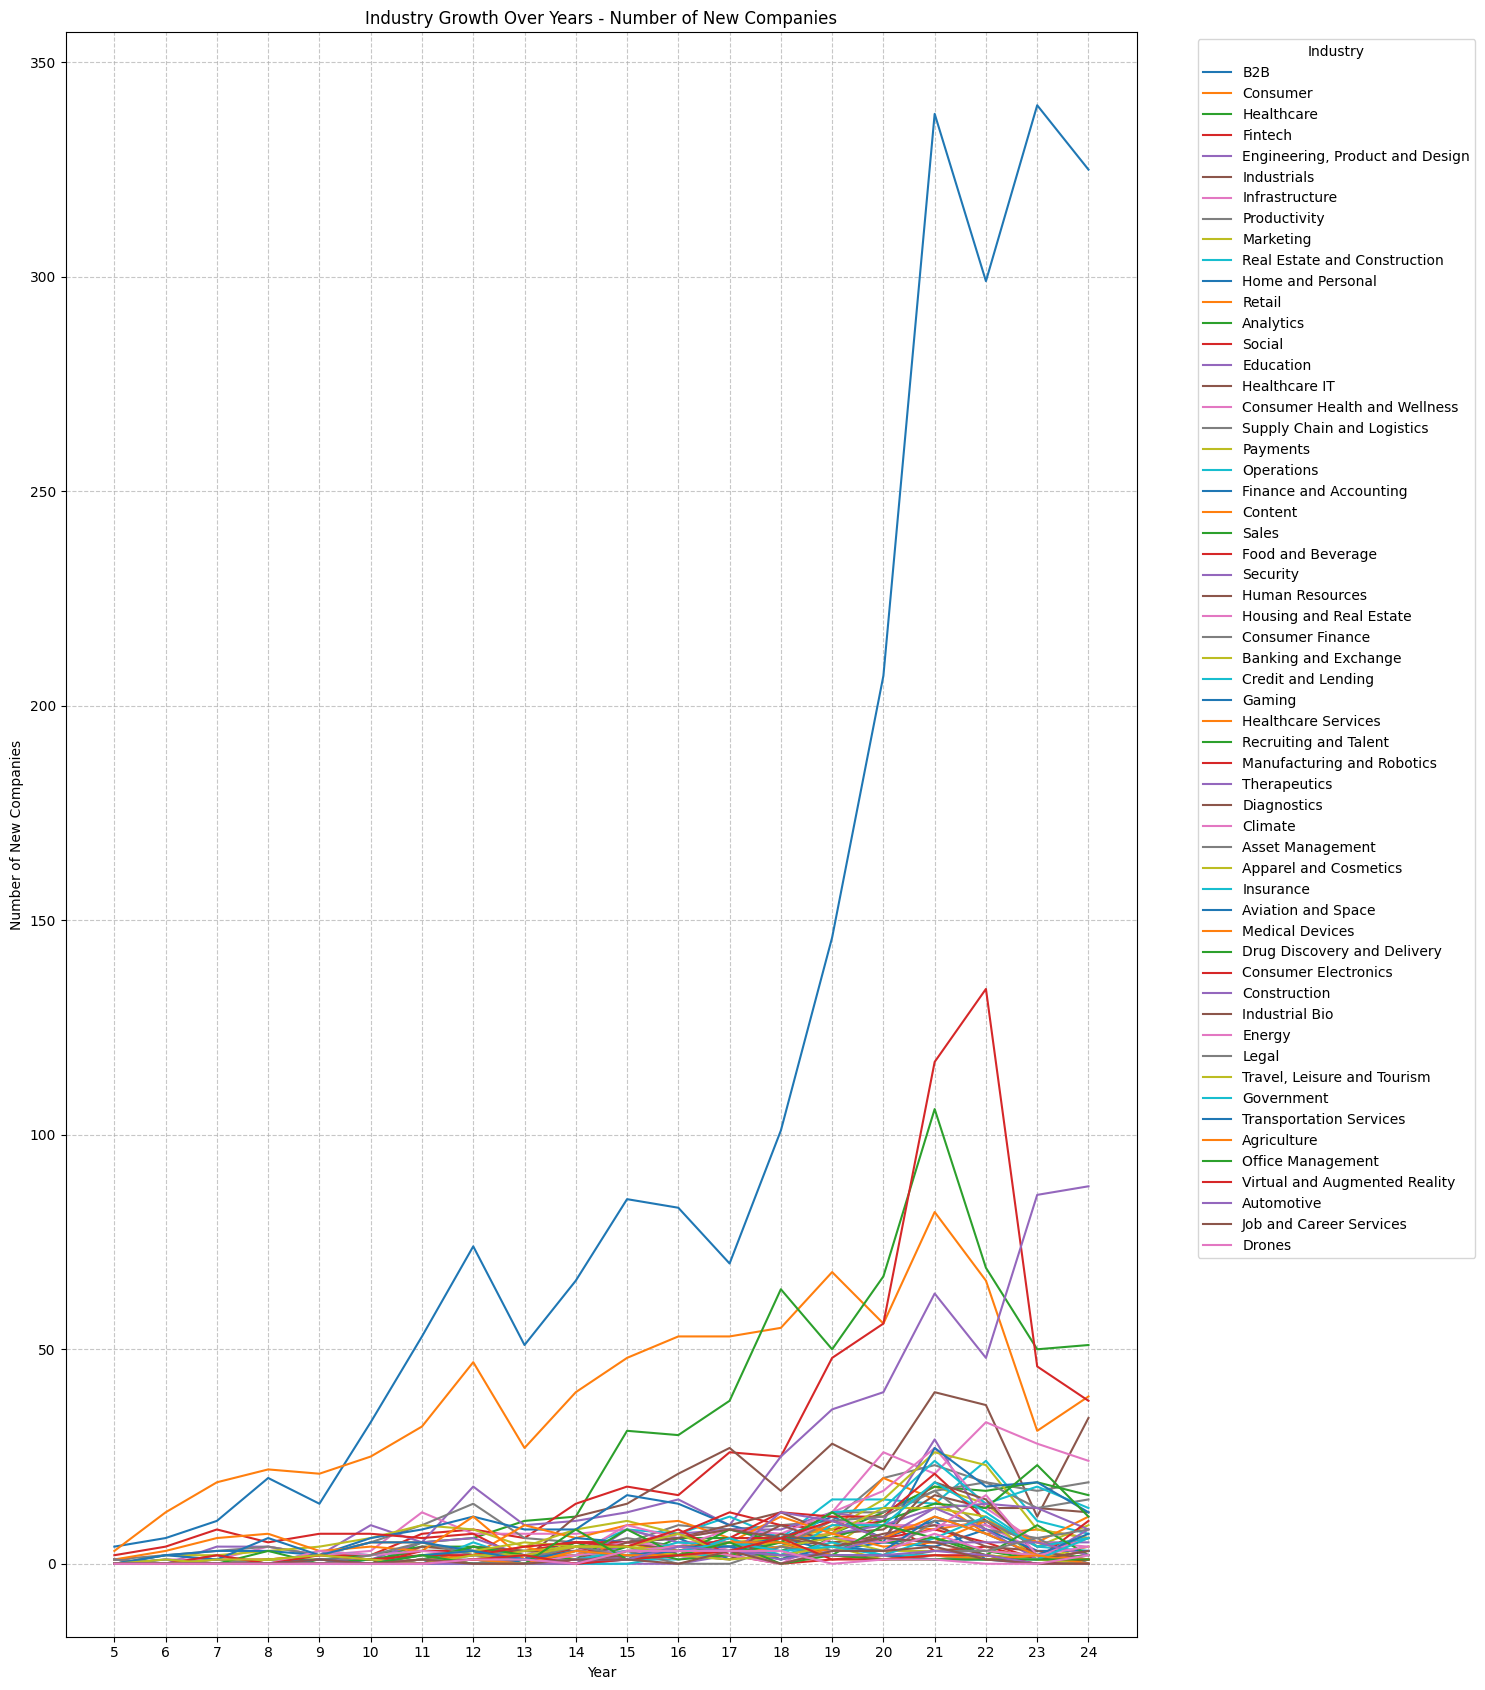

In [17]:
# Convert batch to year assuming format like 'W20' or 'S20' where the last two digits are the year
merged_data['year'] = merged_data['batch'].apply(lambda x: int(x[-2:]) if x else None)

# Group by year and industry to count new companies
growth_data = merged_data.groupby(['year', 'industry']).size().reset_index(name='count')

# Pivot the data for plotting
pivoted_data = growth_data.pivot(index='year', columns='industry', values='count').fillna(0)

# Sort columns by total count to show most significant industries first
industries_sorted = pivoted_data.sum().sort_values(ascending=False).index
pivoted_data = pivoted_data[industries_sorted]

# Create the line chart
plt.figure(figsize=(15, 17))
for industry in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[industry], label=industry)

plt.title('Industry Growth Over Years - Number of New Companies')
plt.xlabel('Year')
plt.ylabel('Number of New Companies')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust x-axis ticks for better readability
plt.xticks(pivoted_data.index, [str(int(year)) if year else '' for year in pivoted_data.index])

plt.tight_layout()
plt.show()